<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Использование-модели-LogisticRegression" data-toc-modified-id="Использование-модели-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Использование модели LogisticRegression</a></span></li><li><span><a href="#Использование-модели-CatBoostClassifier" data-toc-modified-id="Использование-модели-CatBoostClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Использование модели CatBoostClassifier</a></span></li><li><span><a href="#Использование-модели-LGBMClassifier" data-toc-modified-id="Использование-модели-LGBMClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Использование модели LGBMClassifier</a></span></li><li><span><a href="#Сравнительная-таблица" data-toc-modified-id="Сравнительная-таблица-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Сравнительная таблица</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install optuna -q

In [2]:
!pip install -U catboost==1.2.7 -q

In [3]:
!pip install pymystem3 -q

In [4]:
!pip install imbalanced-learn -q

In [5]:
!pip install wordcloud -q

In [50]:
# импорт библиотек
import pandas as pd
import numpy as np
import optuna
from time import time
from ipywidgets import IntProgress

import nltk, os
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

from nltk.tag.perceptron import PerceptronTagger
from catboost.text_processing import Tokenizer
from pymystem3 import Mystem
import re

# импортируем устранитель дисбаланса данных целевого класса
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC

from wordcloud import WordCloud
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.pipeline import Pipeline 
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 

from sklearn.preprocessing import (                             
    QuantileTransformer,
    PowerTransformer,
    OneHotEncoder, 
    OrdinalEncoder,
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures
)

from nltk.corpus import stopwords  
import nltk                        

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# отключить warnings
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

In [7]:
!pip freeze

alembic==1.13.1
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1708355285029/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///D:/bld/argon2-cffi-bindings_1695386877556/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1696128962909/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1698341106958/work
async-lru @ file:///home/conda/feedstock_root/build_artifacts/async-lru_1690563019058/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1704011227531/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1702422572539/work
beautifulsoup4==4.9.3
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1696630167146/work
Brotli @ file:///D:/bld/brotli-split_1695989908365/work
cached-property @ file:///home/conda/feedstock_root/build_artifacts/cached_property_1615209429212/work
catboost==1.2.7
certifi @ file:

In [8]:
skip_EDA = False

In [9]:
# Загрузим данные
data = pd.read_csv("toxic_comments.csv")

In [10]:
# Функция освобождения памяти за счет сжатия данных
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    print(col, 'int8')
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    print(col, 'int16')
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    print(col, 'int32')
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    print(col, 'int64')
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    print(col, 'float32')
                    df[col] = df[col].astype(np.float32)
                else:
                    print(col, 'float64')
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.
                                  format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [11]:
# Освободим память
data = reduce_mem_usage(data)

Unnamed: 0 int32
toxic int8
Mem. usage decreased to  1.97 Mb (45.8% reduction)


In [12]:
data.shape

(159292, 3)

In [13]:
# Посмотрим на данные
data.head(2)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0


In [14]:
# Проверим пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int32 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int8  
dtypes: int32(1), int8(1), object(1)
memory usage: 2.0+ MB


In [15]:
# Проверим дубликаты
print(data['text'].duplicated().sum())

0


In [16]:
# Проверим соответствие данных в столбце целевого признака
data['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

<Axes: xlabel='toxic'>

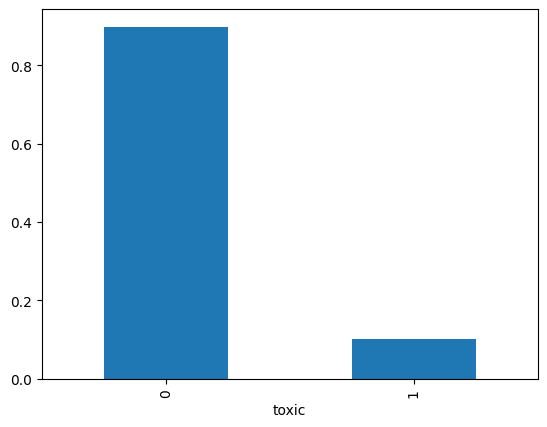

In [17]:
# Визуализируем дисбаланс данных в столбце целевого признака
data.toxic.value_counts(normalize=True).plot(kind='bar')

Обнаружен сильный дисбаланс классов целевого признака: негативных оценок на порядок меньше положительных.

In [18]:
# Загрузим словарь ненужных слов
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\len-
[nltk_data]     user-1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Иницииализируем токенизатор
tokenizer = Tokenizer(
    lowercasing=True,
    separator_type='BySense',
    token_types=['Word', 'Number']
)

In [20]:
# Функция фильтрации стоп-слов
def filter_stop_words(tokens):
    return list(filter(lambda x: x not in stop_words, tokens))

In [21]:
# Функция установки тегов слов
nltk.download('wordnet')
tagger = PerceptronTagger()

tag_dict = {"J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV}

def get_wordnet_pos_multiple(words):
    pos_tags = tagger.tag(words)
    #pos_tags = nltk.pos_tag(words)
    return [(word, tag_dict.get(tag[0].upper(), wordnet.NOUN)) for word, tag in pos_tags]

[nltk_data] Downloading package wordnet to C:\Users\len-
[nltk_data]     user-1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
# Функция лемматизации
nltk_data_path = os.path.join(os.path.dirname(nltk.__file__), 'nltk_data')
nltk.data.path.append(nltk_data_path)
nltk.download('wordnet', nltk_data_path)
nltk.download('averaged_perceptron_tagger')

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_tokens_nltk(tokens):
    pos_tags = get_wordnet_pos_multiple(tokens)
    return [lemmatizer.lemmatize(token, tag) for token, tag in pos_tags]
    #return list(map(lambda t: lemmatizer.lemmatize(t, get_wordnet_pos(t)), tokens))
    #return list(map(lambda t: lemmatizer.lemmatize(t), tokens))

[nltk_data] Downloading package wordnet to C:\Users\len-
[nltk_data]     user-1\anaconda3\envs\practicum\lib\site-
[nltk_data]     packages\nltk\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\len-user-1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [23]:
# Функция обработки строк датасета
def lemm_func(text):
    tokenized_text = tokenizer.tokenize(text)
    tokenized_text = filter_stop_words(tokenized_text)
    tokenized_text = lemmatize_tokens_nltk(tokenized_text)
    
    return ' '.join(tokenized_text)

In [24]:
data['text'].head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: text, dtype: object

In [28]:
%%time
# Проведем лемматизацию текстов
data['lem_text'] = data['text'].apply(lambda x: lemm_func(x))

CPU times: total: 9min 22s
Wall time: 9min 22s


In [29]:
data['lem_text'].head()

0    explanation edits make username hardcore metal...
1    d'aww match background colour i'm seemingly st...
2    hey man i'm really try edit war guy constantly...
3    can't make real suggestion improvement wonder ...
4                 sir hero chance remember page that's
Name: lem_text, dtype: object

In [30]:
# Получим выборки негативных и позитивных комментариев
data_1 = data.query('toxic == 1')
data_0 = data.query('toxic == 0')

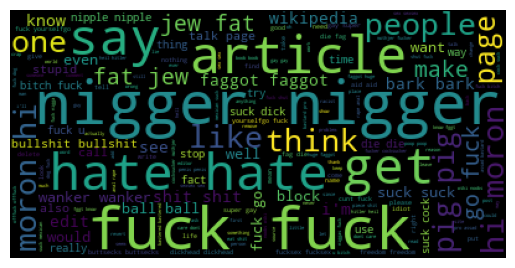

In [31]:
if skip_EDA == False:
    # Выводим облако слов из негативных выражений
    text = ' '.join(data_1['lem_text'])
    cloud = WordCloud(stopwords=stop_words).generate(text)
    plt.imshow(cloud)
    plt.axis('off');

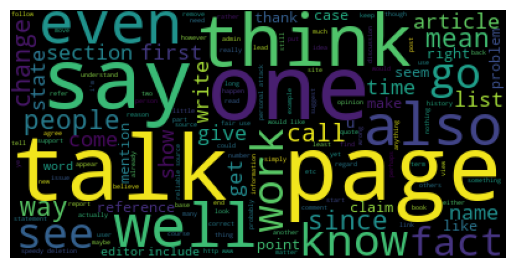

In [32]:
if skip_EDA == False:
    # Выводим облако слов из позитивных выражений
    text = ' '.join(data_0['lem_text'])
    cloud = WordCloud(stopwords=stop_words).generate(text)
    plt.imshow(cloud)
    plt.axis('off');

In [76]:
# Удалим из выборок лишние столбцы
data = data.drop(['Unnamed: 0', 'text'], axis=1)

In [40]:
# Создадим тренировочную и тестовую выборки
TEST_SIZE = 0.1
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['toxic'], axis=1),
    data['toxic'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['toxic']
)

In [43]:
X_train.head(2)

,lem_text
22585,please stop continue vandalize page saint-vict...
150346,chanology nonviolence comment say one edit cha...


In [44]:
print('Размеры тренировочной выборки', X_train.shape)
print('Размеры тестовой выборки', X_test.shape)

Размеры тренировочной выборки (143362, 1)
Размеры тестовой выборки (15930, 1)


In [45]:
# Удалим ненужные переменные
del data, data_0, data_1

Выводы по подготовке данных:

1. В датасет загружена таблица toxic_comments. Датасет имет 159292 строк и 3 столбца. 
2. Столбец 'Unnamed: 0' непригоден в качестве признака. Столбец удален из датасета.
3. Датасет не имеет пропусков, несоответствий и явных дубликатов.
4. Обнаружен сильный дисбаланс классов целевого признака: негативных оценок на порядок меньше положительных. Дисбаланс устранен.
5. Проведена лемматизация и очистка текста.
6. Построены две визуализации облаков наиболее часто применных слов: из негативных и из позитивных высказываний.
7. На основе датасета toxic_comments созданы тренировочная и тестовая выборки.
8. Счетчик TF-IDF и сэмплер RandomOverSampler должен создаваться в пайплане.

## Обучение

### Использование модели LogisticRegression

In [51]:
# функция перебора гиперпараметров для optuna 
def optuna_objective(trial, X_train, y_train, results):
    model, train_score = optuna_train_model(trial, X_train, y_train) 
    if results.get('best_score') == None or results['best_score'] > train_score:
        results['best_model'] = model
        results['best_score'] = train_score
    
    print(f'train_score @ {train_score}')              
    return train_score

In [52]:
# функция установки гиперпарамтров для optuna_objective
def optuna_train_model(trial, X_train, y_train):
    param_distributions = {}
    
    params = {}
    params['C'] = trial.suggest_int('C', 1, 4)

    pipeline = Pipeline([
        ('transformer', ColumnTransformer([
            ('tfidf', TfidfVectorizer(), 'lem_text')
        ], remainder='drop'
        )), 
        ('sampler', RandomOverSampler(random_state=RANDOM_STATE)),
        ('classifier', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1', **params))
    ])

    cval = cross_validate(pipeline, X_train, y_train, cv=5, scoring=['f1'], return_train_score=True)
    print('Метрика F1 на обучающей кросс-валидационной выборке (среднее):', cval['train_f1'].mean())
    print('Метрика F1 на тестовой кросс-валидационной выборке (среднее):', cval['test_f1'].mean())
    score = cval['test_f1'].mean()

    # Обучим модель на обучающей выборке
    pipeline.fit(X_train, y_train)
    
    return pipeline, score

In [53]:
# С помощью optuna произведем обучающий поиск
study = optuna.create_study()
optuna_results = {}
study.optimize(lambda trial: optuna_objective(trial, X_train, y_train, optuna_results), n_trials=5, n_jobs=1, 
               show_progress_bar=True)

[I 2024-10-06 16:08:05,563] A new study created in memory with name: no-name-001279cd-cccf-4a1f-9c2a-912955f871b6


  0%|          | 0/5 [00:00<?, ?it/s]

Метрика F1 на обучающей кросс-валидационной выборке (среднее): 0.9335778682705126
Метрика F1 на тестовой кросс-валидационной выборке (среднее): 0.7573078643414912
train_score @ 0.7573078643414912
[I 2024-10-06 16:09:41,437] Trial 0 finished with value: 0.7573078643414912 and parameters: {'C': 4}. Best is trial 0 with value: 0.7573078643414912.
Метрика F1 на обучающей кросс-валидационной выборке (среднее): 0.9154447454733706
Метрика F1 на тестовой кросс-валидационной выборке (среднее): 0.75901053946941
train_score @ 0.75901053946941
[I 2024-10-06 16:11:14,962] Trial 1 finished with value: 0.75901053946941 and parameters: {'C': 3}. Best is trial 0 with value: 0.7573078643414912.
Метрика F1 на обучающей кросс-валидационной выборке (среднее): 0.9335778682705126
Метрика F1 на тестовой кросс-валидационной выборке (среднее): 0.7573078643414912
train_score @ 0.7573078643414912
[I 2024-10-06 16:12:59,479] Trial 2 finished with value: 0.7573078643414912 and parameters: {'C': 4}. Best is trial 0 

In [54]:
# выведем результаты лучшей модели LogisticRegression
print('best score:', study.best_value)                    
print('best params:', study.best_params)                  
print('best model:', optuna_results['best_model']) 
best_model_1 = optuna_results['best_model']
f1_1 = study.best_value
print('Метрика F1 на кросс-валидации:', f1_1) 

best score: 0.7573078643414912
best params: {'C': 4}
best model: Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'lem_text')])),
                ('sampler', RandomOverSampler(random_state=42)),
                ('classifier',
                 LogisticRegression(C=4, penalty='l1', random_state=42,
                                    solver='liblinear'))])
Метрика F1 на кросс-валидации: 0.7573078643414912


### Использование модели CatBoostClassifier

In [71]:
# функция установки гиперпарамтров для optuna_objective
def optuna_train_model_2(trial, X_train, y_train):
    param_distributions = {}
    
    params = {}
    
    pipeline = Pipeline([
        ('transformer', ColumnTransformer([
            ('tfidf', TfidfVectorizer(), 'lem_text')
        ], remainder='drop'
        )), 
        ('sampler', RandomOverSampler(random_state=RANDOM_STATE)),
        ('classifier', CatBoostClassifier(loss_function='Logloss', iterations=150, **params))
    ])

    cval = cross_validate(pipeline, X_train, y_train, cv=5, scoring=['f1'], return_train_score=True)
    print('Метрика F1 на обучающей кросс-валидационной выборке (среднее):', cval['train_f1'].mean())
    print('Метрика F1 на тестовой кросс-валидационной выборке (среднее):', cval['test_f1'].mean())
    score = cval['test_f1'].mean()

    # Обучим модель на обучающей выборке
    pipeline.fit(X_train, y_train)
    
    return pipeline, score

In [72]:
# функция перебора гиперпараметров для optuna 
def optuna_objective(trial, X_train, y_train, results):
    model, train_score = optuna_train_model_2(trial, X_train, y_train) 
    if results.get('best_score') == None or results['best_score'] > train_score:
        results['best_model'] = model
        results['best_score'] = train_score
    
    print(f'train_score @ {train_score}')              
    return train_score

In [73]:
# С помощью optuna произведем обучающий поиск
study = optuna.create_study()
optuna_results = {}
study.optimize(lambda trial: optuna_objective(trial, X_train, y_train, optuna_results), n_trials=1, n_jobs=1, 
               show_progress_bar=True)

[I 2024-10-06 22:31:25,355] A new study created in memory with name: no-name-3431bf2c-385a-4a00-8f13-0ae2132db181


  0%|          | 0/1 [00:00<?, ?it/s]

Learning rate set to 0.5
0:	learn: 0.5513173	total: 2s	remaining: 4m 57s
1:	learn: 0.5101851	total: 3.89s	remaining: 4m 47s
2:	learn: 0.4795789	total: 5.76s	remaining: 4m 42s
3:	learn: 0.4583332	total: 7.58s	remaining: 4m 36s
4:	learn: 0.4403820	total: 9.45s	remaining: 4m 34s
5:	learn: 0.4273073	total: 11.3s	remaining: 4m 30s
6:	learn: 0.4131088	total: 13.1s	remaining: 4m 27s
7:	learn: 0.4039154	total: 14.9s	remaining: 4m 24s
8:	learn: 0.3956725	total: 16.7s	remaining: 4m 22s
9:	learn: 0.3887446	total: 18.6s	remaining: 4m 20s
10:	learn: 0.3813024	total: 20.4s	remaining: 4m 17s
11:	learn: 0.3746975	total: 22.2s	remaining: 4m 15s
12:	learn: 0.3692574	total: 24.1s	remaining: 4m 13s
13:	learn: 0.3635902	total: 25.8s	remaining: 4m 11s
14:	learn: 0.3582446	total: 27.6s	remaining: 4m 8s
15:	learn: 0.3542627	total: 29.5s	remaining: 4m 6s
16:	learn: 0.3495904	total: 31.3s	remaining: 4m 4s
17:	learn: 0.3460501	total: 33.1s	remaining: 4m 2s
18:	learn: 0.3425497	total: 34.9s	remaining: 4m
19:	lear

6:	learn: 0.4169445	total: 13s	remaining: 4m 25s
7:	learn: 0.4087456	total: 14.8s	remaining: 4m 22s
8:	learn: 0.3979413	total: 16.6s	remaining: 4m 20s
9:	learn: 0.3883534	total: 18.5s	remaining: 4m 18s
10:	learn: 0.3815387	total: 20.3s	remaining: 4m 16s
11:	learn: 0.3747655	total: 22.1s	remaining: 4m 13s
12:	learn: 0.3695917	total: 23.9s	remaining: 4m 11s
13:	learn: 0.3641313	total: 25.7s	remaining: 4m 9s
14:	learn: 0.3590774	total: 27.4s	remaining: 4m 7s
15:	learn: 0.3537100	total: 29.2s	remaining: 4m 4s
16:	learn: 0.3491638	total: 31s	remaining: 4m 2s
17:	learn: 0.3456354	total: 32.8s	remaining: 4m
18:	learn: 0.3406955	total: 34.6s	remaining: 3m 58s
19:	learn: 0.3372973	total: 36.4s	remaining: 3m 56s
20:	learn: 0.3339139	total: 38.2s	remaining: 3m 54s
21:	learn: 0.3308382	total: 40s	remaining: 3m 52s
22:	learn: 0.3278756	total: 41.7s	remaining: 3m 50s
23:	learn: 0.3245314	total: 43.5s	remaining: 3m 48s
24:	learn: 0.3216955	total: 45.3s	remaining: 3m 46s
25:	learn: 0.3192169	total: 47

13:	learn: 0.3664478	total: 26s	remaining: 4m 12s
14:	learn: 0.3605458	total: 27.8s	remaining: 4m 10s
15:	learn: 0.3549649	total: 29.6s	remaining: 4m 7s
16:	learn: 0.3506345	total: 31.5s	remaining: 4m 6s
17:	learn: 0.3461147	total: 33.2s	remaining: 4m 3s
18:	learn: 0.3425744	total: 35s	remaining: 4m 1s
19:	learn: 0.3393335	total: 36.8s	remaining: 3m 59s
20:	learn: 0.3349201	total: 38.7s	remaining: 3m 57s
21:	learn: 0.3316389	total: 40.5s	remaining: 3m 55s
22:	learn: 0.3286881	total: 42.3s	remaining: 3m 53s
23:	learn: 0.3248941	total: 44.1s	remaining: 3m 51s
24:	learn: 0.3221715	total: 45.9s	remaining: 3m 49s
25:	learn: 0.3186239	total: 47.7s	remaining: 3m 47s
26:	learn: 0.3160297	total: 49.5s	remaining: 3m 45s
27:	learn: 0.3136637	total: 51.2s	remaining: 3m 43s
28:	learn: 0.3110124	total: 53s	remaining: 3m 41s
29:	learn: 0.3084604	total: 54.8s	remaining: 3m 39s
30:	learn: 0.3061029	total: 56.6s	remaining: 3m 37s
31:	learn: 0.3039685	total: 58.4s	remaining: 3m 35s
32:	learn: 0.3008012	t

20:	learn: 0.3353148	total: 1m 5s	remaining: 6m 40s
21:	learn: 0.3327651	total: 1m 8s	remaining: 6m 36s
22:	learn: 0.3300223	total: 1m 11s	remaining: 6m 33s
23:	learn: 0.3267615	total: 1m 14s	remaining: 6m 28s
24:	learn: 0.3231988	total: 1m 16s	remaining: 6m 24s
25:	learn: 0.3204585	total: 1m 19s	remaining: 6m 21s
26:	learn: 0.3178970	total: 1m 23s	remaining: 6m 19s
27:	learn: 0.3155646	total: 1m 26s	remaining: 6m 15s
28:	learn: 0.3125607	total: 1m 29s	remaining: 6m 11s
29:	learn: 0.3096283	total: 1m 32s	remaining: 6m 8s
30:	learn: 0.3072139	total: 1m 35s	remaining: 6m 5s
31:	learn: 0.3051384	total: 1m 38s	remaining: 6m 1s
32:	learn: 0.3025044	total: 1m 40s	remaining: 5m 57s
33:	learn: 0.3003670	total: 1m 43s	remaining: 5m 54s
34:	learn: 0.2973513	total: 1m 46s	remaining: 5m 51s
35:	learn: 0.2955861	total: 1m 49s	remaining: 5m 47s
36:	learn: 0.2937401	total: 1m 52s	remaining: 5m 44s
37:	learn: 0.2917696	total: 1m 55s	remaining: 5m 40s
38:	learn: 0.2898392	total: 1m 58s	remaining: 5m 37

26:	learn: 0.3140826	total: 1m 12s	remaining: 5m 28s
27:	learn: 0.3119653	total: 1m 14s	remaining: 5m 25s
28:	learn: 0.3090237	total: 1m 17s	remaining: 5m 23s
29:	learn: 0.3067413	total: 1m 20s	remaining: 5m 22s
30:	learn: 0.3040466	total: 1m 23s	remaining: 5m 20s
31:	learn: 0.3018598	total: 1m 26s	remaining: 5m 17s
32:	learn: 0.2993196	total: 1m 28s	remaining: 5m 15s
33:	learn: 0.2973445	total: 1m 31s	remaining: 5m 12s
34:	learn: 0.2938635	total: 1m 34s	remaining: 5m 10s
35:	learn: 0.2919521	total: 1m 37s	remaining: 5m 7s
36:	learn: 0.2900497	total: 1m 40s	remaining: 5m 5s
37:	learn: 0.2875907	total: 1m 42s	remaining: 5m 2s
38:	learn: 0.2856849	total: 1m 45s	remaining: 4m 59s
39:	learn: 0.2837091	total: 1m 48s	remaining: 4m 57s
40:	learn: 0.2819356	total: 1m 51s	remaining: 4m 55s
41:	learn: 0.2799014	total: 1m 54s	remaining: 4m 53s
42:	learn: 0.2784793	total: 1m 56s	remaining: 4m 50s
43:	learn: 0.2768338	total: 1m 59s	remaining: 4m 48s
44:	learn: 0.2752957	total: 2m 2s	remaining: 4m 4

29:	learn: 0.3105625	total: 1m 7s	remaining: 4m 29s
30:	learn: 0.3067395	total: 1m 9s	remaining: 4m 25s
31:	learn: 0.3047164	total: 1m 11s	remaining: 4m 23s
32:	learn: 0.3024620	total: 1m 13s	remaining: 4m 21s
33:	learn: 0.2998339	total: 1m 15s	remaining: 4m 18s
34:	learn: 0.2974978	total: 1m 17s	remaining: 4m 16s
35:	learn: 0.2954241	total: 1m 19s	remaining: 4m 13s
36:	learn: 0.2933702	total: 1m 21s	remaining: 4m 10s
37:	learn: 0.2917611	total: 1m 23s	remaining: 4m 6s
38:	learn: 0.2900715	total: 1m 25s	remaining: 4m 3s
39:	learn: 0.2883735	total: 1m 27s	remaining: 4m
40:	learn: 0.2869450	total: 1m 29s	remaining: 3m 57s
41:	learn: 0.2849860	total: 1m 31s	remaining: 3m 54s
42:	learn: 0.2834401	total: 1m 33s	remaining: 3m 52s
43:	learn: 0.2820287	total: 1m 35s	remaining: 3m 49s
44:	learn: 0.2806033	total: 1m 37s	remaining: 3m 47s
45:	learn: 0.2790674	total: 1m 39s	remaining: 3m 44s
46:	learn: 0.2776430	total: 1m 41s	remaining: 3m 41s
47:	learn: 0.2756287	total: 1m 43s	remaining: 3m 39s
4

In [74]:
# выведем результаты лучшей модели CatBoostClassifier
print('best score:', study.best_value)                    
print('best params:', study.best_params)                  
print('best model:', optuna_results['best_model'])
f1_2 = study.best_value
print('Метрика F1 на кросс-валидации:', f1_2) 

best score: 0.74269395239767
best params: {}
best model: Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'lem_text')])),
                ('sampler', RandomOverSampler(random_state=42)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x0000026B235D0EB0>)])
Метрика F1 на кросс-валидации: 0.74269395239767


### Использование модели LGBMClassifier

In [59]:
# функция установки гиперпарамтров для optuna_objective
def optuna_train_model_3(trial, X_train, y_train):
    param_distributions = {}
    
    params = {}
    params['num_boost_round'] = trial.suggest_int('num_boost_round', 2, 100)
    params['num_leaves'] = trial.suggest_int('num_leaves', 2, 200)
    params['max_depth'] = trial.suggest_int('max_depth', 2, 10)
    params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', 5, 10)
    
    pipeline = Pipeline([
        ('transformer', ColumnTransformer([
            ('tfidf', TfidfVectorizer(), 'lem_text')
        ], remainder='drop'
        )), 
        ('sampler', RandomOverSampler(random_state=RANDOM_STATE)),
        ('classifier', LGBMClassifier(boosting_type='gbdt', **params))
    ])

    #model = LGBMClassifier(boosting_type='gbdt', **params)

    cval = cross_validate(pipeline, X_train, y_train, cv=5, scoring=['f1'], return_train_score=True)
    print('Метрика F1 на обучающей кросс-валидационной выборке (среднее):', cval['train_f1'].mean())
    print('Метрика F1 на тестовой кросс-валидационной выборке (среднее):', cval['test_f1'].mean())
    score = cval['test_f1'].mean()

    # Обучим модель на обучающей выборке
    pipeline.fit(X_train, y_train)
    
    return pipeline, score

In [55]:
# функция перебора гиперпараметров для optuna 
def optuna_objective(trial, X_train, y_train, results):
    model, train_score = optuna_train_model_3(trial, X_train, y_train) 
    if results.get('best_score') == None or results['best_score'] > train_score:
        results['best_model'] = model
        results['best_score'] = train_score
        
    print(f'train_score @ {train_score}')              
    return train_score

In [60]:
# С помощью optuna произведем обучающий поиск
study = optuna.create_study()
optuna_results = {}
study.optimize(lambda trial: optuna_objective(trial, X_train, y_train, optuna_results), n_trials=5, n_jobs=1, 
               show_progress_bar=True)

[I 2024-10-06 16:48:58,670] A new study created in memory with name: no-name-55de4858-fc8a-470c-8ea4-36ba5a4f8148


  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] num_iterations is set=72, num_boost_round=72 will be ignored. Current value: num_iterations=72
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] num_iterations is set=72, num_boost_round=72 will be ignored. Current value: num_iterations=72
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] num_iterations is set=72, num_boost_round=72 will be ignored. Current value: num_iterations=72
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] num_iterations is set=72, num_boost_round=72 will be ignored. Current value: num_iterations=72
[LightGBM] [Warning] min_data_in_leaf is set=9, min_chil

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] num_iterations is set=10, num_boost_round=10 will be ignored. Current value: num_iterations=10
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] num_iterations is set=10, num_boost_round=10 will be ignored. Current value: num_iterations=10
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] num_iterations is set=10, num_boost_round=10 will be ignored. Current value: num_iterations=10
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] num_iterations is set=10, num_boost_round=10 will be ignored. Current value: num_iterations=10
[LightGBM] [Warning] min_data_in_leaf is set=7, min_chil

In [61]:
# выведем результаты лучшей модели LGBMClassifier
print('best score:', study.best_value)                    
print('best params:', study.best_params)                  
print('best model:', optuna_results['best_model'])
f1_3 = study.best_value
print('Метрика F1 на кросс-валидации:', f1_3) 

best score: 0.522823694459961
best params: {'num_boost_round': 10, 'num_leaves': 152, 'max_depth': 2, 'min_data_in_leaf': 7}
best model: Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'lem_text')])),
                ('sampler', RandomOverSampler(random_state=42)),
                ('classifier',
                 LGBMClassifier(max_depth=2, min_data_in_leaf=7,
                                num_boost_round=10, num_leaves=152))])
Метрика F1 на кросс-валидации: 0.522823694459961


### Сравнительная таблица

In [75]:
# Составим сравнительную таблицу показателей метрики F1 для разных моделей МО
print('Сравнительная таблица значений метрики F1')
list_1 = ['LogisticRegression', 'CatBoostClassifier', 'LGBMClassifier']
list_2 = [f1_1, f1_2, f1_3]
df_f1 = pd.DataFrame()
df_f1['Model'] = np.array(list_1)
df_f1['Score'] = np.array(list_2)
df_f1['Score'] =df_f1['Score'].apply(lambda x: round(x, 2))
df_f1

Сравнительная таблица значений метрики F1


,Model,Score
0,LogisticRegression,0.76
1,CatBoostClassifier,0.74
2,LGBMClassifier,0.52


In [69]:
# применим лучшую модель LogisticRegression к тестовой выборке
y_pred_test = best_model_1.predict(X_test)
f1_test = f1_score(y_test, y_pred_test)
print('Метрика F1 на тестовой выборке:', f1_test) 

Метрика F1 на тестовой выборке: 0.7692307692307693


Выводы по обучению моделей:

1. Для обучения использованы модели LGBMClassifier, LogisticRegression и CatBoostClassifier.
2. При обучении всех моделей используются инструменты optuna и пайплан.
3. Для контроля качества обучения применяется метрика F1.
5. Полученные значения метрики сведены в сравнительнуё таблицу.
6. Модель логистической регрессии показала метрику F1 = 0.76
7. Модель CatBoostClassifier показала метрику F1 = 0.74
8. Модель LGBMClassifier, даже с применением optuna, показала низкую метрику F1 = 0.52
9. Лучшей оказалась модель LogisticRegression. Её оценка на тестовой выборке: F1 = 0.77

## Выводы

1. В датасет загружена таблица toxic_comments. Датасет имет 159292 строк и 3 столбца. 
2. Столбец 'Unnamed: 0' непригоден в качестве признака. Столбец удален из датасета.
3. Датасет не имеет пропусков, несоответствий и явных дубликатов.
4. Обнаружен сильный дисбаланс классов целевого признака: негативных оценок на порядок меньше положительных. Дисбаланс устранен.
5. Проведена демматизация и очистка текста.
6. Построены две визуализации облаков наиболее частот применных слов: из негативных и из позитивных высказываний.
7. На основе датасета toxic_comments созданы тренировочная и тестовая выборки.
8. Счетчик TF-IDF и сэмплер RandomOverSampler создаются в пайплане.
9. Для обучения использованы модели LGBMClassifier, LogisticRegression и CatBoostClassifier.
10. При обучении моделей LGBMClassifier и LogisticRegression используется инструмент optuna.
11. Для контроля качества обучения применяется метрика F1 на кросс-валидации.
12. Полученные значения метрики сведены в сравнительнуё таблицу.
13. Модель логистической регрессии показала метрику F1 = 0.76
14. Модель CatBoostClassifier показала метрику F1 = 0.74
15. Модель LGBMClassifier, даже с применением optuna, показала низкую метрику F1 = 0.52
16. Лучшей оказалась модель LogisticRegression. Её оценка на тестовой выборке: F1 = 0.77